# ** If you are running on Binder **

You should:
- Launch a new Desktop tab by going to New -> Desktop in the index page ([screenshot](../_images/binder-desktop.png))

- then uncomment and execute the code below:

In [ ]:
#import os
#os.environ['DISPLAY'] = ':1.0'

# Preamble

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
import napari

# Introduction to three-dimensional image processing

Images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Some 3D images are constructed with equal resolution in each dimension; e.g., a computer generated rendering of a sphere. Most experimental data captures one dimension at a lower resolution than the other two; e.g., photographing thin slices to approximate a 3D structure as a stack of 2D images. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

## Input/Output and display

Three dimensional data can be loaded with `skimage.io.imread`. The data for this tutorial was provided by the Allen Institute for Cell Science. It has been downsampled by a factor of 4 in the `row` and `column` dimensions to reduce computational time.

In [3]:
nuclei = io.imread('../images/cells.tif')
membranes = io.imread('../images/cells_membrane.tif')

print("shape: {}".format(nuclei.shape))
print("dtype: {}".format(nuclei.dtype))
print("range: ({}, {})".format(np.min(nuclei), np.max(nuclei)))

shape: (60, 256, 256)
dtype: float64
range: (0.0, 1.0)


The distance between pixels was reported by the microscope used to image the cells. This `spacing` information will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to normalize it to `1.0` in the `row` and `column` dimensions.

In [4]:
# The microscope reports the following spacing (in µm)
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]

print(f'microscope spacing: {original_spacing}')
print(f'after rescaling images: {rescaled_spacing}')
print(f'normalized spacing: {spacing}')

microscope spacing: [0.29  0.065 0.065]
after rescaling images: [0.29 0.26 0.26]
normalized spacing: [1.11538462 1.         1.        ]


We can view the 3D image using napari.

In [5]:
viewer = napari.view_image(nuclei, contrast_limits=[0, 1],
                           scale=spacing)

## Exposure

`skimage.exposure` contains a number of functions for adjusting image contrast. These functions operate on pixel values. Generally, image dimensionality or pixel spacing does not need to be considered.

[Gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), also known as Power Law Transform, brightens or darkens an image. The function $O = I^\gamma$ is applied to each pixel in the image. A `gamma < 1` will brighten an image, while a `gamma > 1` will darken an image.

napari has a built-in gamma correction slider for image layers. Try playing with the gamma slider to see its effect on the image.

In [7]:
# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) improves contrast in an image by redistributing pixel intensities. The most common pixel intensities are spread out, allowing areas of lower local contrast to gain a higher contrast. This may enhance background noise.

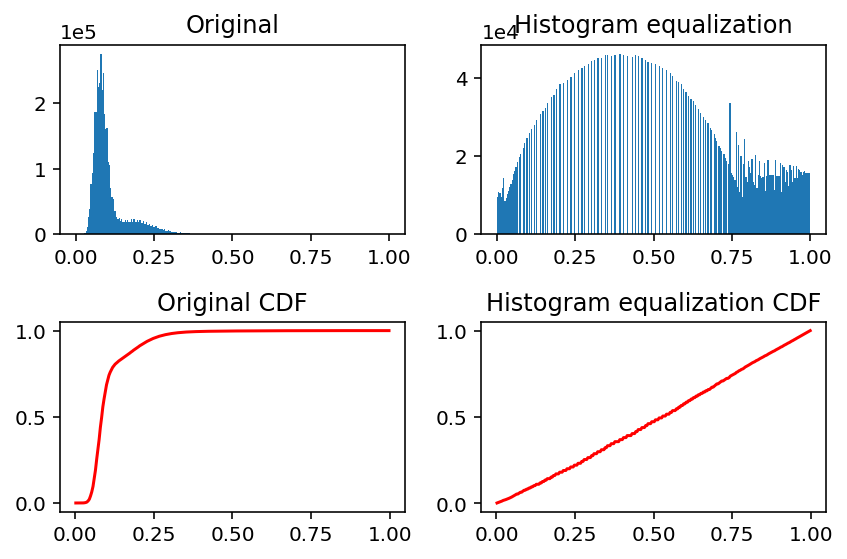

In [8]:
equalized = exposure.equalize_hist(nuclei)

fig, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2)

plot_hist(a, nuclei, title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = exposure.cumulative_distribution(nuclei.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

fig.tight_layout()

We can look at the image in our napari viewer:

In [9]:
viewer.add_image(equalized, contrast_limits=[0, 1], name='histeq')

<Image layer 'histeq' at 0x7fab229139d0>

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

In [10]:
vmin, vmax = np.quantile(nuclei, q=(0.005, 0.995))

stretched = exposure.rescale_intensity(
    nuclei, 
    in_range=(vmin, vmax), 
    out_range=np.float32
)

viewer.add_image(stretched, contrast_limits=[0, 1], name='stretched')

<Image layer 'stretched' at 0x7fab1d6b68b0>

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

We saw the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) in the filters lesson. It is an edge detection algorithm that approximates the gradient of the image intensity, and is fast to compute. `skimage.filters.sobel` has not been adapted for 3D images, but it can be readily generalised (see the linked Wikipedia entry). Let's try it!

In [11]:
edges = filters.sobel(nuclei)

viewer = napari.view_image(nuclei, blending='additive', colormap='green', name='nuclei')
viewer.add_image(edges, blending='additive', colormap='magenta', name='edges')

<Image layer 'edges' at 0x7fab337a5a90>

In [13]:
denoised = ndi.median_filter(nuclei, size=3)

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and Li's minimum cross entropy threshold are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

In [14]:
li_thresholded = denoised > filters.threshold_li(denoised)

In [15]:
viewer.add_image(li_thresholded, name='thresholded', opacity=0.3)

<Image layer 'thresholded' at 0x7fab1e2a2ee0>

We can see holes due to variations of the image intensity inside the nuclei. We can actually fill them with `scipy.ndimage.binary_fill_holes`.

In [16]:
filled = ndi.binary_fill_holes(li_thresholded)

viewer.add_image(filled, name='filled', opacity=0.3)

<Image layer 'filled' at 0x7fab1a62b460>

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

Morphology operations can be chained together to denoise an image. For example, a `closing` applied to an `opening` can remove salt and pepper noise from an image.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a `min_size` parameter, which is the minimum size (in pixels) of accepted holes or objects. The `min_size` can be approximated by a cube.

In [17]:
width = 20

remove_holes = morphology.remove_small_holes(
    filled, 
    area_threshold=width ** 3
)

In [18]:
width = 20

remove_objects = morphology.remove_small_objects(
    remove_holes, 
    min_size=width ** 3
)

viewer.add_image(remove_objects, name='cleaned', opacity=0.3);

## Segmentation

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Interger labels are assigned to each region to distinguish regions of interest.

In [19]:
labels = measure.label(remove_objects)

viewer.add_labels(labels, name='labels')

<Labels layer 'labels' at 0x7fab1c4fe250>

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. Markers are placed at local minima/maxima and expanded outward until there is a collision with markers from another region, with the image intensity serving as a guide for the marker boundaries.

It can be quite challenging to find markers with the right location. A slight amount of noise in the image can result in very wrong point locations. Here is a common approach: find the distance from the object boundaries, then place points at the maximal distance.

In [20]:
transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

maxima = morphology.local_maxima(transformed)
viewer.add_points(np.transpose(np.nonzero(maxima)), name='bad points')

<Points layer 'bad points' at 0x7fab06c91580>

With napari, we can combine interactive point selections with the automated watershed algorithm from `skimage.morphology`:

In [21]:
viewer.layers['bad points'].visible = False
points = viewer.add_points(name='interactive points')
points.mode = 'add'

# now, annotate the centers of the nuclei in your image

In [22]:
marker_locations = points.data

markers = np.zeros(nuclei.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
    edges,
    markers_big, 
    mask=remove_objects
)

viewer.add_labels(segmented, name='segmented')

<Labels layer 'segmented' at 0x7faae844ce50>

After watershed, we have better disambiguation between internal cells!

## Making measurements

Once we have defined our objects, we can make measurements on them using `skimage.measure.regionprops` and the new `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [23]:
interior_labels = segmentation.clear_border(segmented)

After clearing the border, the object labels are no longer sequentially increasing. Optionally, the labels can be renumbered such that there are no jumps in the list of image labels.

In [24]:
relabeled, _, _ = segmentation.relabel_sequential(interior_labels)

print("relabeled labels: {}".format(np.unique(relabeled)))

relabeled labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [25]:
viewer.add_labels(relabeled)

<Labels layer 'relabeled' at 0x7faae84dc730>

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below are lists of supported and unsupported 3D measurements.

In [26]:
regionprops = measure.regionprops(relabeled, intensity_image=nuclei)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

Supported properties:
  area
  bbox
  bbox_area
  centroid
  convex_area
  convex_image
  coords
  equivalent_diameter
  euler_number
  extent
  filled_area
  filled_image
  image
  inertia_tensor
  inertia_tensor_eigvals
  intensity_image
  label
  local_centroid
  major_axis_length
  max_intensity
  mean_intensity
  min_intensity
  minor_axis_length
  moments
  moments_central
  moments_normalized
  slice
  solidity
  weighted_centroid
  weighted_local_centroid
  weighted_moments
  weighted_moments_central
  weighted_moments_normalized

Unsupported properties:
  eccentricity
  moments_hu
  orientation
  perimeter
  weighted_moments_hu


`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [ ]:
print(f'measured regions: {[regionprop.label for regionprop in regionprops]}')

`regionprops_table` returns a dictionary of columns compatible with creating a pandas dataframe of properties of the data:

In [27]:
import pandas as pd


info_table = pd.DataFrame(
    measure.regionprops_table(
        relabeled, nuclei,
        properties=['label', 'slice', 'area', 'mean_intensity'],
    )
).set_index('label')

In [28]:
info_table

,slice,area,mean_intensity
label,,,
1,"(slice(20, 53, None), slice(13, 55, None), sli...",37410,0.189264
2,"(slice(19, 51, None), slice(47, 99, None), sli...",40504,0.185613
3,"(slice(19, 55, None), slice(26, 71, None), sli...",36062,0.211760
4,"(slice(20, 52, None), slice(23, 75, None), sli...",36987,0.181163
5,"(slice(20, 52, None), slice(115, 167, None), s...",47604,0.212577
6,"(slice(19, 54, None), slice(72, 121, None), sl...",40130,0.211141
7,"(slice(17, 53, None), slice(133, 184, None), s...",42514,0.247120
8,"(slice(17, 58, None), slice(120, 159, None), s...",48231,0.232108
9,"(slice(19, 52, None), slice(158, 209, None), s...",40226,0.198043


We can now use pandas for some analysis!

In [29]:
info_table.describe()

,area,mean_intensity
count,11.000000,11.000000
mean,43335.727273,0.210335
std,6688.715827,0.020856
min,36062.000000,0.181163
25%,38770.000000,0.193653
50%,40504.000000,0.211760
75%,47917.500000,0.222448
max,58046.000000,0.247120


## Challenge problems

Put your 3D image processing skills to the test by working through these challenge problems.

### Improve the segmentation

A few objects were oversegmented in the declumping step. Try to improve the segmentation and assign each object a single, unique label. You can try to use [calibrated denoising](https://scikit-image.org/docs/dev/auto_examples/filters/plot_j_invariant.html) to get smoother nuclei and membrane images.

### Segment cell membranes

Try segmenting the accompanying membrane channel. In the membrane image, the membrane walls are the bright web-like regions. This channel is difficult due to a high amount of noise in the image. Additionally, it can be hard to determine where the membrane ends in the image (it's not the first and last planes).

Below is a 2D segmentation of the membrane:

![](../_images/membrane_segmentation.png)

Hint: there should only be one nucleus per membrane.

### Measure the area in µm³ of the cells

Once you have segmented the cell membranes, use regionprops to measure the distribution of cell areas.